In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU, Dense, Reshape, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm 

import warnings
warnings.filterwarnings("ignore")

In [2]:
(x_train, _), (_, _) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# **Normalization**

In [3]:
print("*************************** BEFORE NORMALIZATON ***************************\n")
print(x_train[0])
x_train = x_train/255
print("\n\n\n---------------------------------------------------------------------------\n\n\n")
print("************************** AFTER NORMALIZATON ***************************\n")
print(x_train[0])

*************************** BEFORE NORMALIZATON ***************************

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0 

Adjusting dimensions (28x28) --> (28, 28, 1)

In [4]:
print("Before Adjusting Dimensions x_train shape: ", x_train.shape)
x_train = np.expand_dims(x_train, axis=-1)
print("After Adjusting Dimensions x_train shape: ", x_train.shape)

Before Adjusting Dimensions x_train shape:  (60000, 28, 28)
After Adjusting Dimensions x_train shape:  (60000, 28, 28, 1)


In [5]:
def build_discriminator():
    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same", input_shape=(28,28,1)))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5), metrics=["accuracy"])

    return model

In [6]:
build_discriminator().summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,769 (315.50 KB)

 Trainable params: 80,769 (315.50 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
z_dim=100
def build_generator():
    model = Sequential()

    model.add(Dense(7*7*128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7,7,128)))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="tanh"))

    return model

In [8]:
build_generator().summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 6272)                │         633,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 708,609 (2.70 MB)

 Trainable params: 708,225 (2.70 MB)

 Non-trainable params: 384 (1.50 KB)

In [9]:
def build_gan(generator, discriminator):
    discriminator.trainable = False

    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss="binary_crossentropy", optimizer= Adam(0.0002, 0.5))

    return model

In [10]:
discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator)

In [11]:
gan.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 28, 28, 1)           │         708,609 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 1)                   │          80,769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 789,378 (3.01 MB)

 Trainable params: 708,225 (2.70 MB)

 Non-trainable params: 81,153 (317.00 KB)

In [16]:
epochs = 500
batch_size = 64
half_batch = batch_size // 2

for epoch in tqdm(range(epochs), desc = "Training Process"):
    idx = np.random.randint(0, x_train.shape[0], half_batch)
    real_images = x_train[idx]
    real_labels = np.ones((half_batch, 1))

    noise = np.random.normal(0, 1, (half_batch, z_dim))
    fake_images = generator.predict(noise, verbose = 0)
    fake_labels = np.zeros((half_batch, 1))

    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
    d_loss = np.add(d_loss_real, d_loss_fake) * 0.5

    noise = np.random.normal(0, 1, (batch_size, z_dim))
    valid_y = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_y)

    if epoch %100 == 0:
        print(f"\n{epoch}/{epochs} d_loss: {d_loss[0]}, g_loss: {g_loss[0]}")

Training Process:   0%|          | 1/1000 [00:00<11:13,  1.48it/s]


0/1000d_loss: 0.9107078313827515, g_loss: 0.9112374782562256


Training Process:  10%|█         | 101/1000 [01:10<10:42,  1.40it/s]


100/1000d_loss: 0.980239987373352, g_loss: 0.9806863069534302


Training Process:  20%|██        | 201/1000 [02:23<09:57,  1.34it/s]


200/1000d_loss: 1.0324357748031616, g_loss: 1.0328030586242676


Training Process:  30%|███       | 301/1000 [03:42<09:14,  1.26it/s]


300/1000d_loss: 1.0719105005264282, g_loss: 1.0722182989120483


Training Process:  40%|████      | 401/1000 [05:03<08:16,  1.21it/s]


400/1000d_loss: 1.1026427745819092, g_loss: 1.1029070615768433


Training Process:  50%|█████     | 501/1000 [06:28<07:05,  1.17it/s]


500/1000d_loss: 1.1272474527359009, g_loss: 1.1274793148040771


Training Process:  60%|██████    | 601/1000 [07:56<05:54,  1.12it/s]


600/1000d_loss: 1.1473684310913086, g_loss: 1.1475729942321777


Training Process:  70%|███████   | 701/1000 [09:28<04:41,  1.06it/s]


700/1000d_loss: 1.1641643047332764, g_loss: 1.1643483638763428


Training Process:  80%|████████  | 801/1000 [11:05<03:12,  1.03it/s]


800/1000d_loss: 1.1783849000930786, g_loss: 1.1785515546798706


Training Process:  90%|█████████ | 901/1000 [12:44<01:39,  1.01s/it]


900/1000d_loss: 1.1905739307403564, g_loss: 1.1907261610031128


Training Process: 100%|██████████| 1000/1000 [14:25<00:00,  1.15it/s]


In [21]:
def plot_generated_images(generator, examples=10, dim=(1, 10)):
    noise = np.random.normal(0, 1, (examples, z_dim))
    gen_images = generator.predict(noise, verbose=0)
    gen_images = 0.5 * gen_images + 0.5

    plt.figure(figsize=(10,1))
    for i in range(gen_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(gen_images[i, :, :, 0], cmap="gray")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

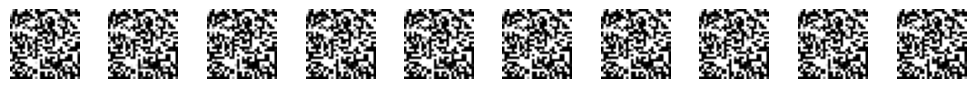

In [22]:
plot_generated_images(generator)